In [1]:
#package imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from scipy import ndimage
import seaborn as sns
import shapely as shp

In [2]:
streets = gpd.read_file('../../data/raw/Road_Centerline/geo_export_c02761a8-1d85-477e-a5cf-01b9f22f4d88.shp')
street_columns = ['joinid', 'roadclass', 'fullname', 'geometry']
streets = streets[street_columns]
streets = streets.dissolve(by='joinid', aggfunc='first')
streets['roadclass'] = streets.roadclass.fillna('Other')

neighborhoods = gpd.read_file('../../data/raw/Neighborhood_Statistical_Areas/Neighborhood_Statistical_Areas.shp')
nhood_columns = ['OBJECTID', 'GNOCDC_LAB', 'geometry']
neighborhoods = neighborhoods[nhood_columns]
neighborhoods.columns = ['nhood_id', 'nhood', 'geometry']
neighborhoods.set_index('nhood_id', inplace=True)
neighborhoods = neighborhoods.to_crs(epsg=4326)

sample_data = pd.read_pickle('../../data/processed/all_samples.pickle')
sample_data['datetime'] = pd.to_datetime(sample_data.date)

accidents = pd.read_pickle('../../data/interim/features/accidents.pickle')
accidents['geometry'] = list(zip(accidents.lon, accidents.lat))
accidents['geometry'] = accidents.geometry.apply(shp.geometry.Point)
accidents = gpd.GeoDataFrame(accidents, geometry='geometry')
accidents.crs = {'init' :'epsg:4326'}

# Maps

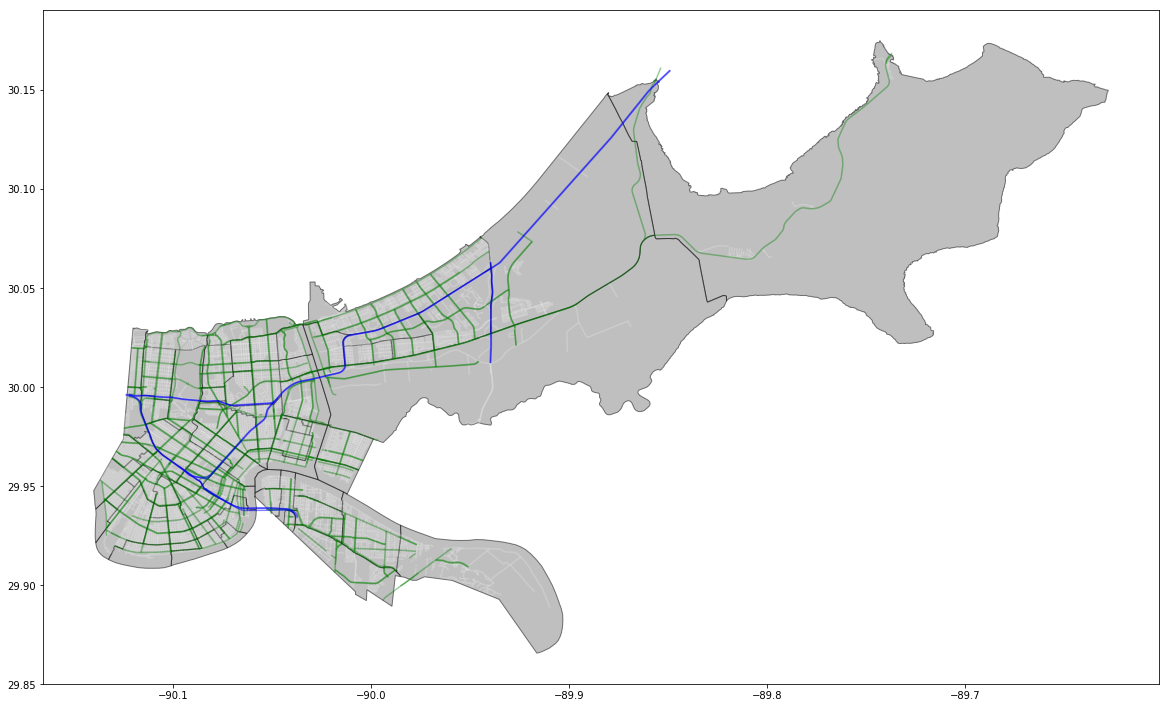

In [3]:
figure_size = (20, 20)

nhood_base = neighborhoods.plot(figsize=figure_size,
                                color='gray',
                                edgecolor='black',
                                alpha=.5)

streets_local = streets[streets['roadclass'] == 'Local'].plot(ax=nhood_base,
                                                              figsize=figure_size,
                                                              color='white',
                                                              alpha=.2)

streets_major = streets[streets['roadclass'] == 'Major Arterial'].plot(ax=streets_local,
                                                                       figsize=figure_size,
                                                                       color='green',
                                                                       alpha=.4)

streets_freeway = streets[streets['roadclass'] == 'Freeway'].plot(ax=streets_major,
                                                                  figsize=figure_size,
                                                                  color='blue',
                                                                  alpha=.5)

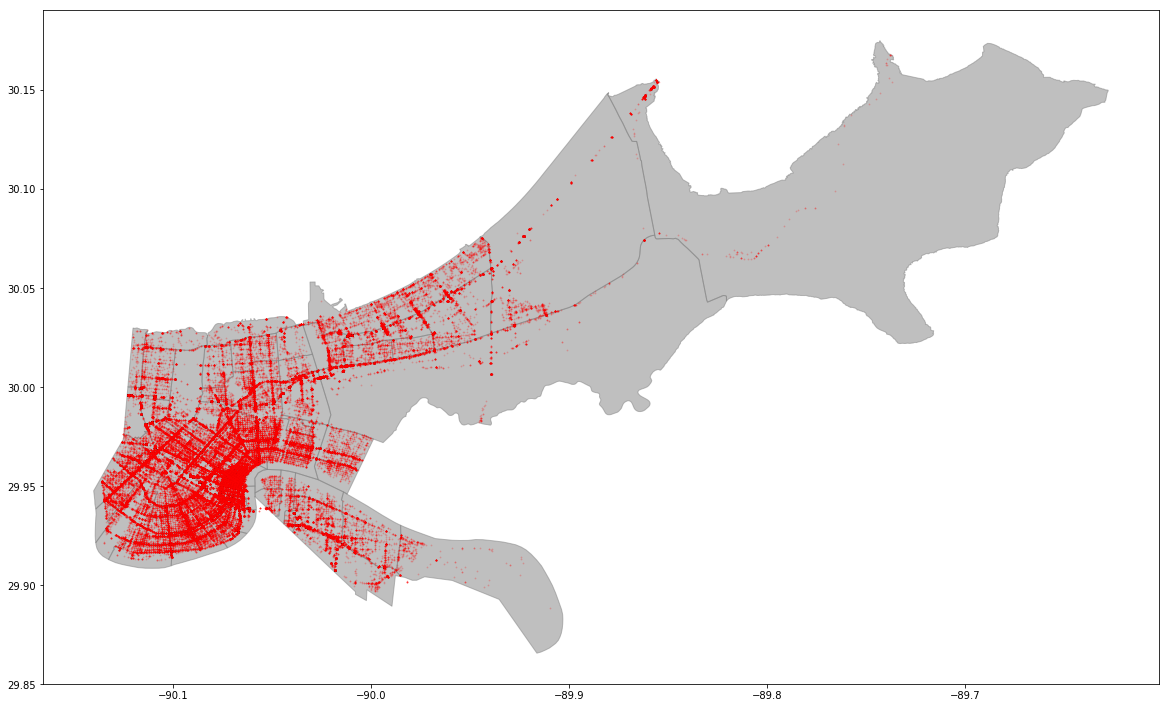

In [4]:
nhood_base = neighborhoods.plot(figsize=figure_size,
                                color='gray',
                                edgecolor='gray',
                                alpha=.5)

accidents.plot(ax=nhood_base, marker='*', color='red', markersize=1, alpha=.2)

# Charts

In [5]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'][0] = 16
plt.rcParams['figure.figsize'][1] = 9

In [6]:
accident_samples = sample_data[sample_data['accident_yn'] == 1].copy()

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr','May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
accident_samples['month'] = pd.Categorical(accident_samples.datetime.dt.strftime('%b'), categories=months)

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
accident_samples['day'] = pd.Categorical(accident_samples.datetime.dt.strftime('%a'), categories=days)

## Accident Counts by Date

**Month**

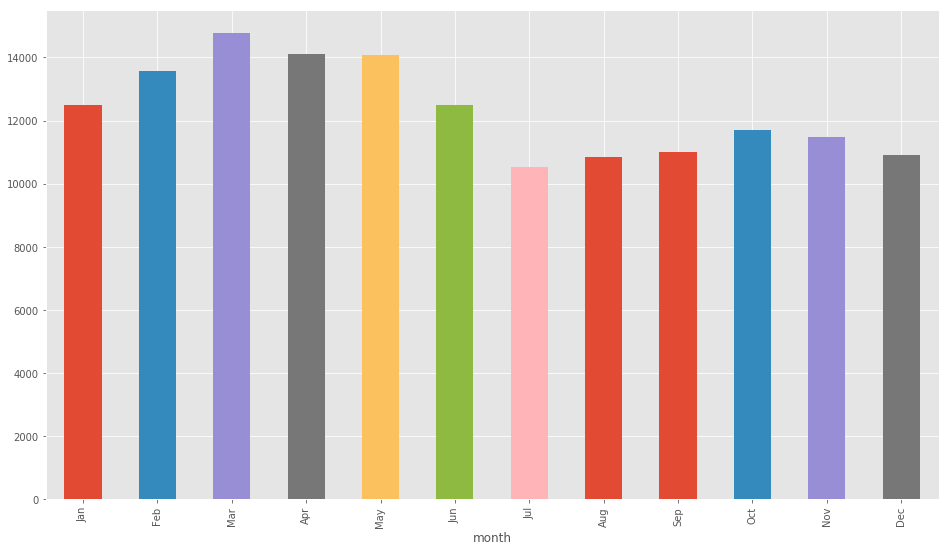

In [8]:
_ = accident_samples.groupby(['month']).size().plot(kind='bar')

**Day of Week**

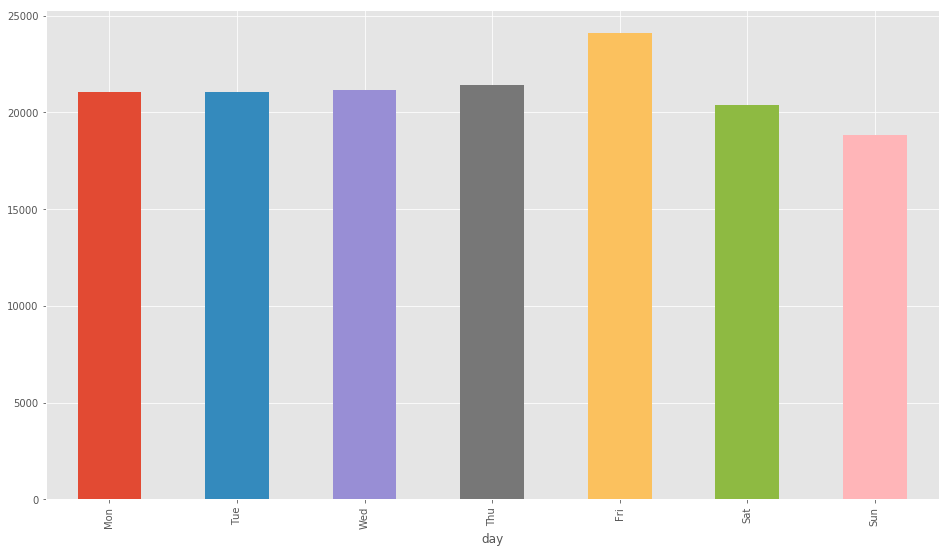

In [9]:
_ = accident_samples.groupby(['day']).size().plot(kind='bar')

**Hour of Day**

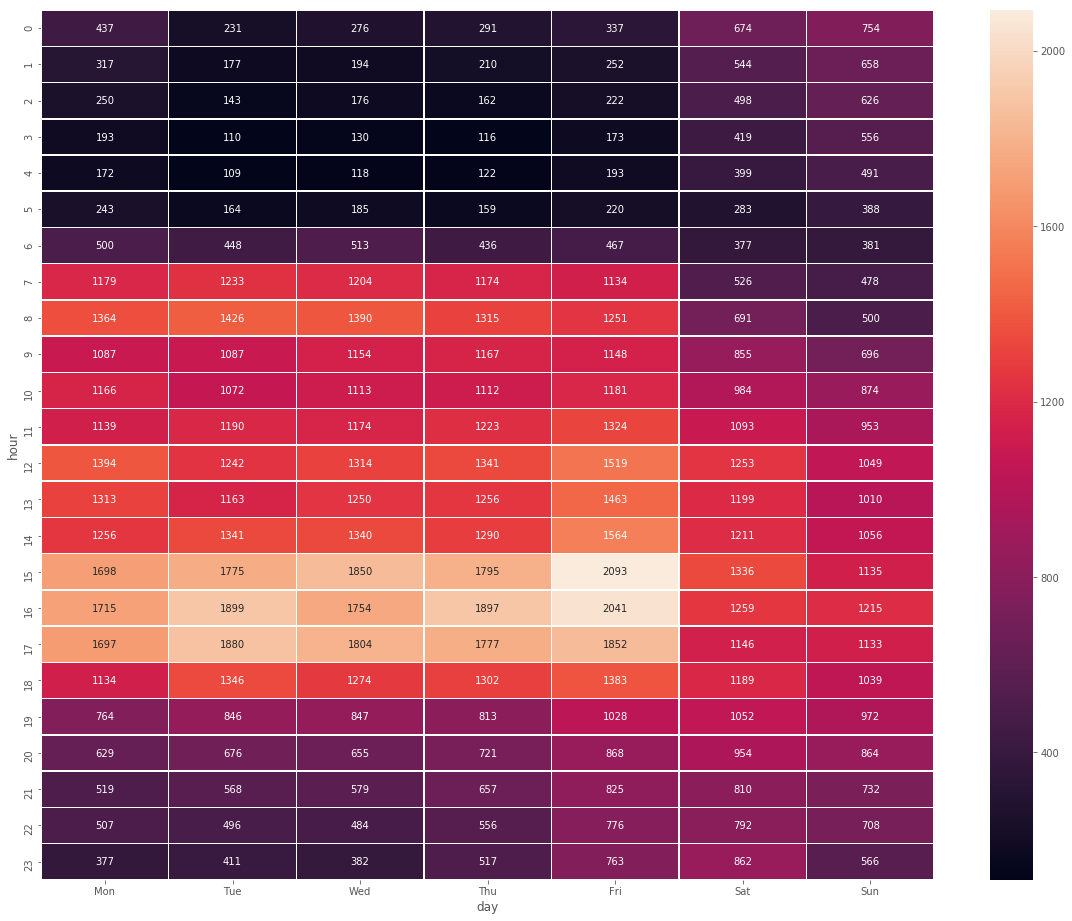

In [10]:
accidents_by_day_hour = accident_samples.groupby(['day', 'hour']).size().reset_index()
accidents_by_day_hour.columns = ['day', 'hour', 'accidents']

accidents_by_day_hour_pivoted = accidents_by_day_hour.pivot('hour', 'day', 'accidents')

f, ax = plt.subplots(figsize=(20, 16))

_ = sns.heatmap(accidents_by_day_hour_pivoted, annot=True, fmt='d', linewidths=.5, ax=ax)

**Daylight**

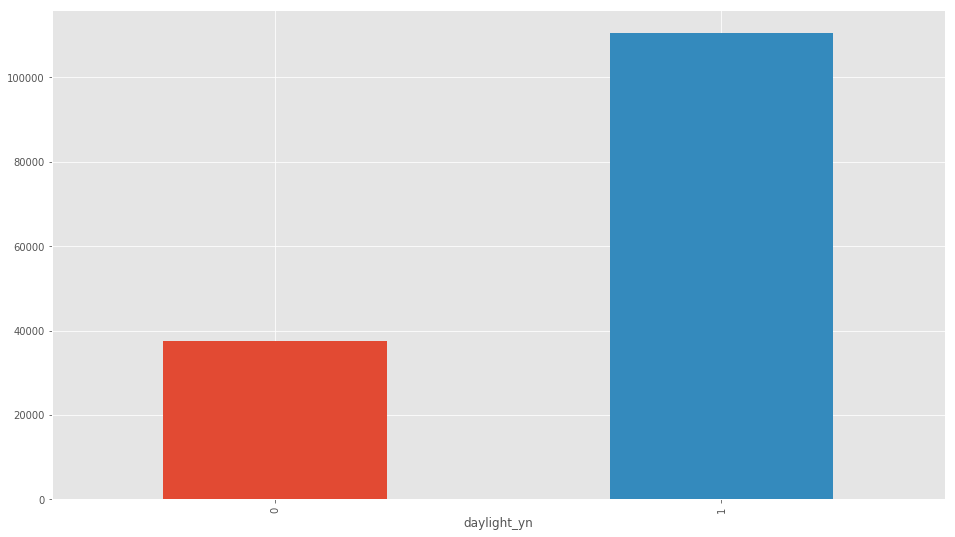

In [11]:
_ = accident_samples.groupby(['daylight_yn']).size().plot(kind='bar')

**Holiday**

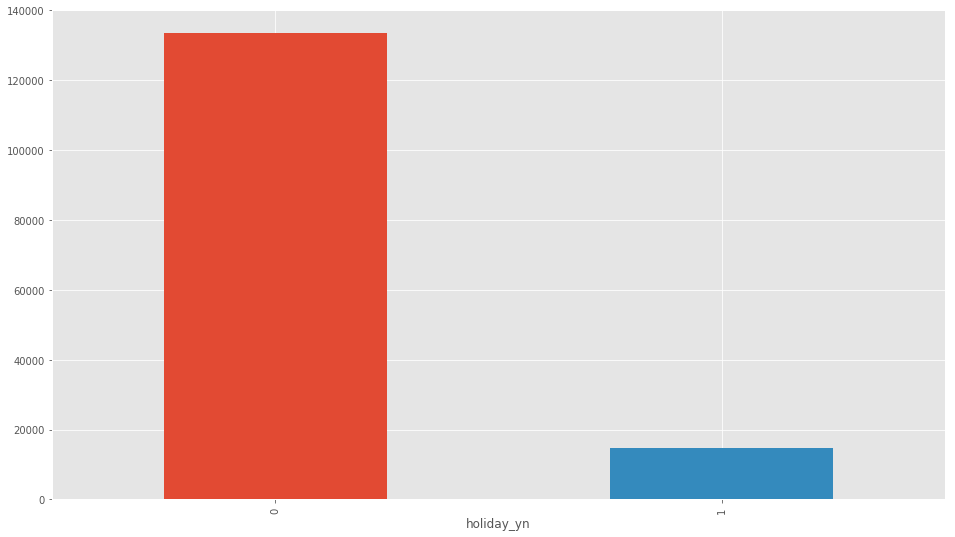

In [12]:
_ = accident_samples.groupby(['holiday_yn']).size().plot(kind='bar')

**Rush Hour**

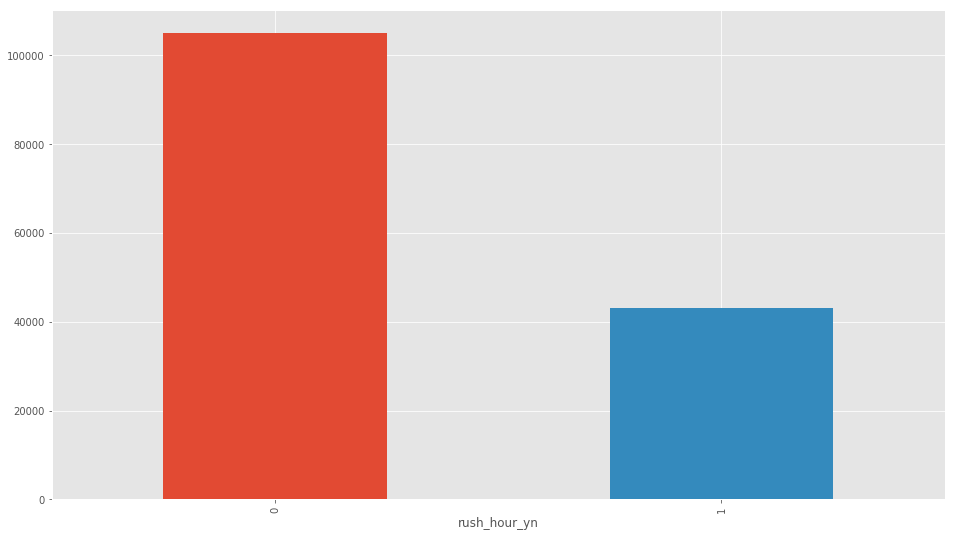

In [13]:
_ = accident_samples.groupby(['rush_hour_yn']).size().plot(kind='bar')

## Weather Distribution

**Temperature**

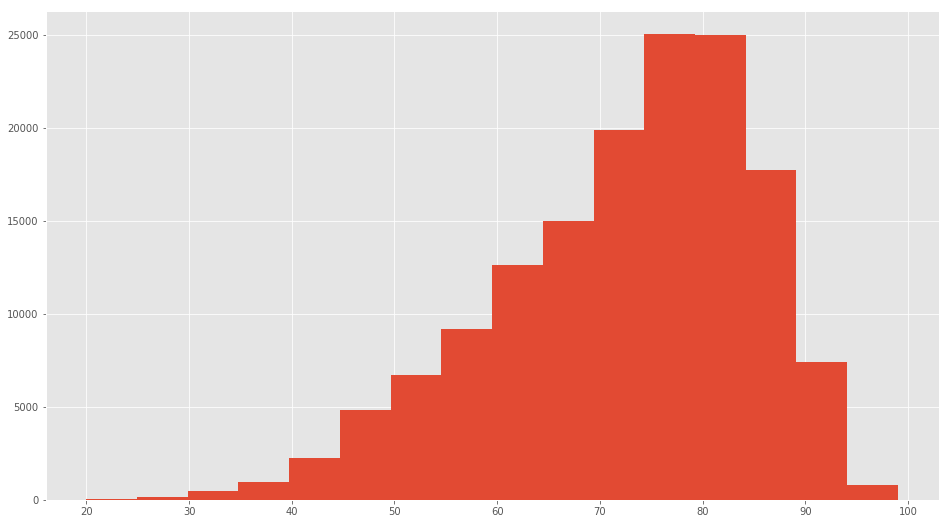

In [14]:
_ = plt.hist(accident_samples.temp, bins=16)

**Wind**

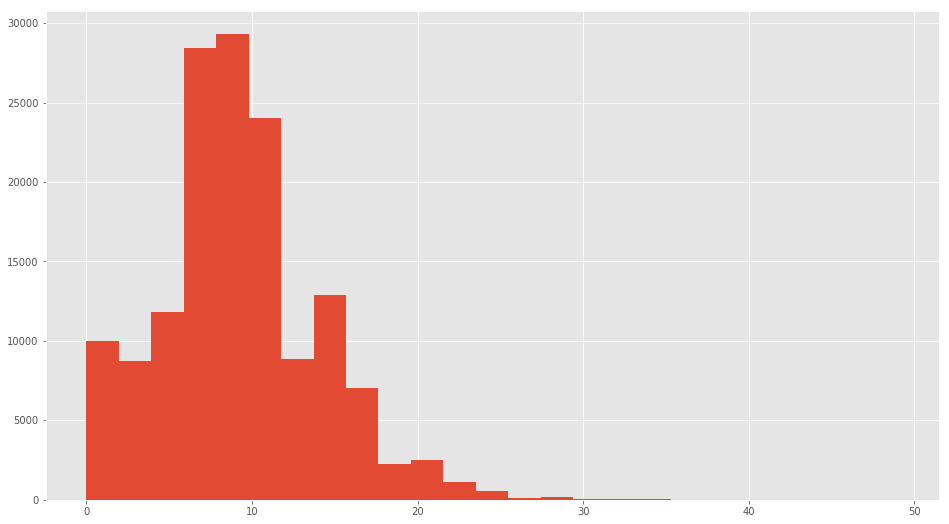

In [15]:
_ = plt.hist(accident_samples.wind_speed, bins=25)

**Precipitation**

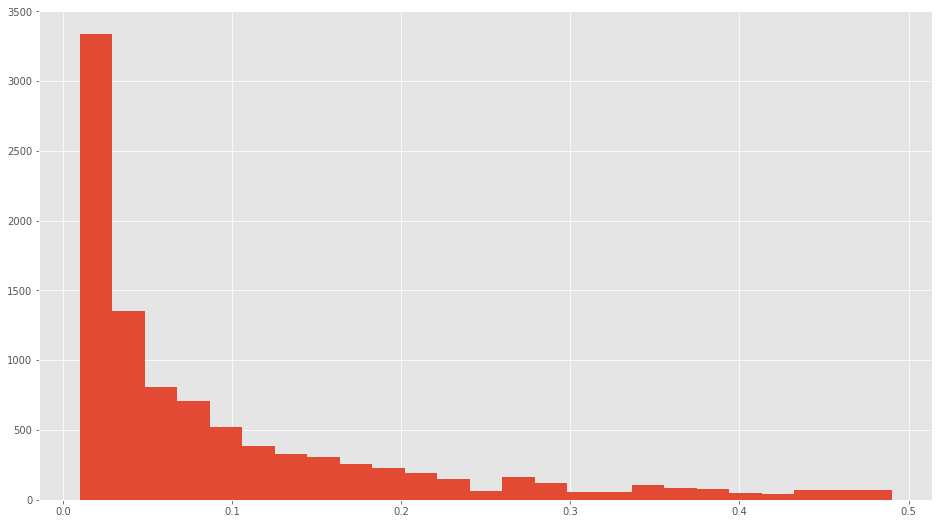

In [16]:
rain_plot = accident_samples[(accident_samples.precipitation > 0) & (accident_samples.precipitation < .5)].precipitation
_ = plt.hist(rain_plot, bins=25)

## Roads

**Type**

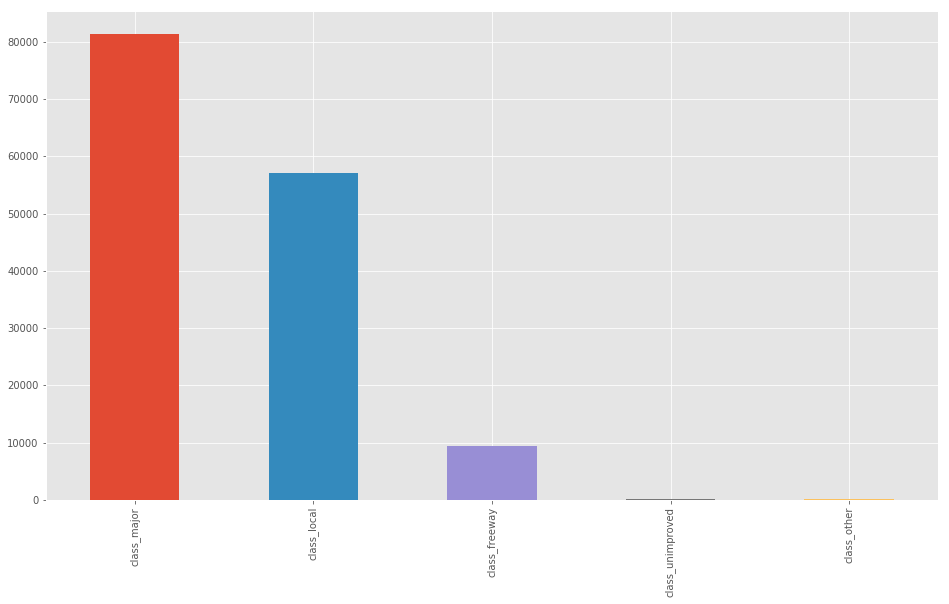

In [17]:
road_classes = ['class_freeway', 'class_local', 'class_major', 'class_other', 'class_unimproved']

_ = accident_samples[road_classes].idxmax(axis=1).value_counts().plot(kind='bar')

**Length**

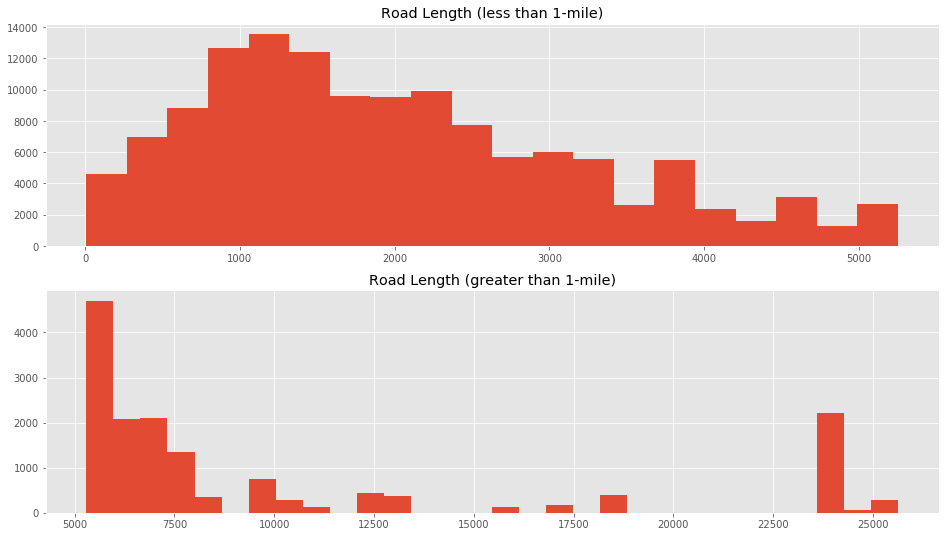

In [18]:
_ = plt.subplot(2, 1, 1)
_ = plt.hist(accident_samples[accident_samples.road_length < 5280].road_length, bins=20)
_ = plt.title('Road Length (less than 1-mile)')
_ = plt.subplot(2, 1, 2)
_ = plt.hist(accident_samples[accident_samples.road_length >= 5280].road_length, bins=30)
_ = plt.title('Road Length (greater than 1-mile)')

plt.rcParams['figure.figsize'][0] = 16
plt.rcParams['figure.figsize'][1] = 20